이 노트북은 [케라스 창시자에게 배우는 딥러닝 2판](https://tensorflow.blog/kerasdl2/)의 예제 코드를 담고 있습니다.

<table align="left">
    <tr>
        <td>
            <a href="https://colab.research.google.com/github/rickiepark/deep-learning-with-python-2nd/blob/main/chapter09_part03_interpreting-what-convnets-learn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
        </td>
    </tr>
</table>

## 컨브넷이 학습한 것 해석하기

### 중간 활성화 시각화

In [ ]:
# 이전 장에서 만든 "convnet_from_scratch_with_augmentation.keras" 파일을 업로드하세요.
# from google.colab import files
# files.upload()

# 또는 다음 코드의 주석을 제거하하고 깃허브에서 파일을 다운로드할 수 있습니다.
!wget https://github.com/rickiepark/deep-learning-with-python-2nd/raw/main/convnet_from_scratch_with_augmentation.keras

--2023-08-28 11:03:31--  https://github.com/rickiepark/deep-learning-with-python-2nd/raw/main/convnet_from_scratch_with_augmentation.keras
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rickiepark/deep-learning-with-python-2nd/main/convnet_from_scratch_with_augmentation.keras [following]
--2023-08-28 11:03:32--  https://raw.githubusercontent.com/rickiepark/deep-learning-with-python-2nd/main/convnet_from_scratch_with_augmentation.keras
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7994528 (7.6M) [application/octet-stream]
Saving to: ‘convnet_from_scratch_with_augmentation.keras’

convnet_f

In [ ]:
from tensorflow import keras
model = keras.models.load_model("convnet_from_scratch_with_augmentation.keras")
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 87, 87, 64)        18496     
                                                           

**한 개의 이미지 전처리하기**

In [ ]:
from tensorflow import keras
import numpy as np

img_path = keras.utils.get_file(
    fname="cat.jpg",
    origin="https://img-datasets.s3.amazonaws.com/cat.jpg")

def get_img_array(img_path, target_size):
    img = keras.utils.load_img(
        img_path, target_size=target_size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

img_tensor = get_img_array(img_path, target_size=(180, 180))

80329/80329 [==============================] - 0s 5us/step


**테스트 이미지 출력하기**

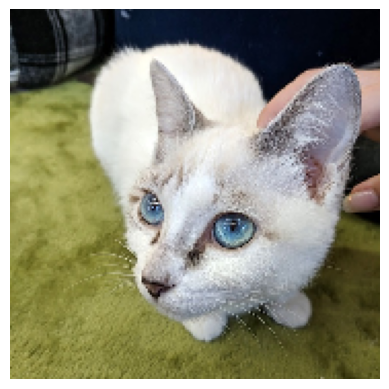

In [ ]:
import matplotlib.pyplot as plt
plt.axis("off")
plt.imshow(img_tensor[0].astype("uint8"))
plt.show()

**층 활성화를 반환하는 모델 만들기**

In [ ]:
from tensorflow.keras import layers

layer_outputs = []
layer_names = []
for layer in model.layers:
    if isinstance(layer, (layers.Conv2D, layers.MaxPooling2D)):
        layer_outputs.append(layer.output)
        layer_names.append(layer.name)
activation_model = keras.Model(inputs=model.input, outputs=layer_outputs)

**층 활성화 계산하기**

In [ ]:
activations = activation_model.predict(img_tensor)

1/1 [==============================] - 7s 7s/step


In [ ]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 178, 178, 32)


**다섯 번째 채널 시각화하기**

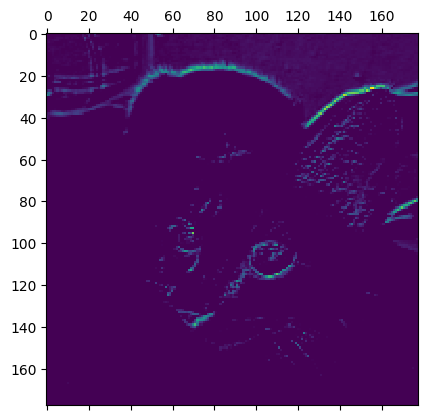

In [ ]:
import matplotlib.pyplot as plt
plt.matshow(first_layer_activation[0, :, :, 5], cmap="viridis")
plt.show()

**모든 층의 활성화에 있는 전체 채널 시각화하기**

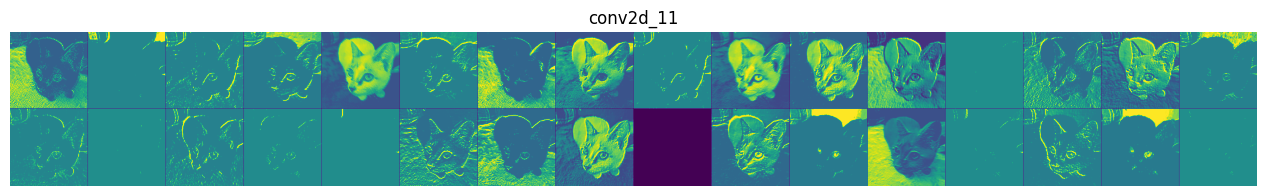

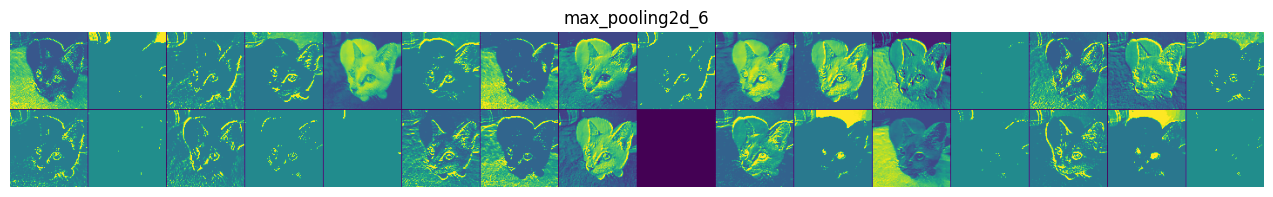

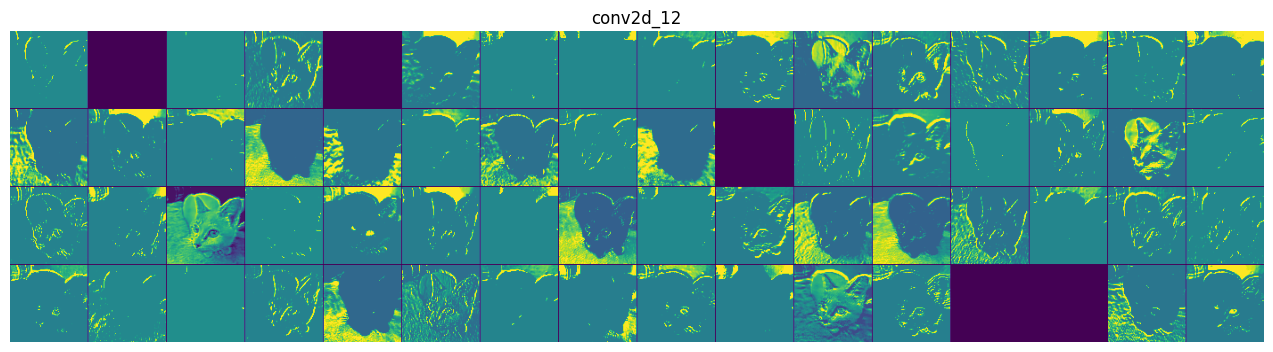

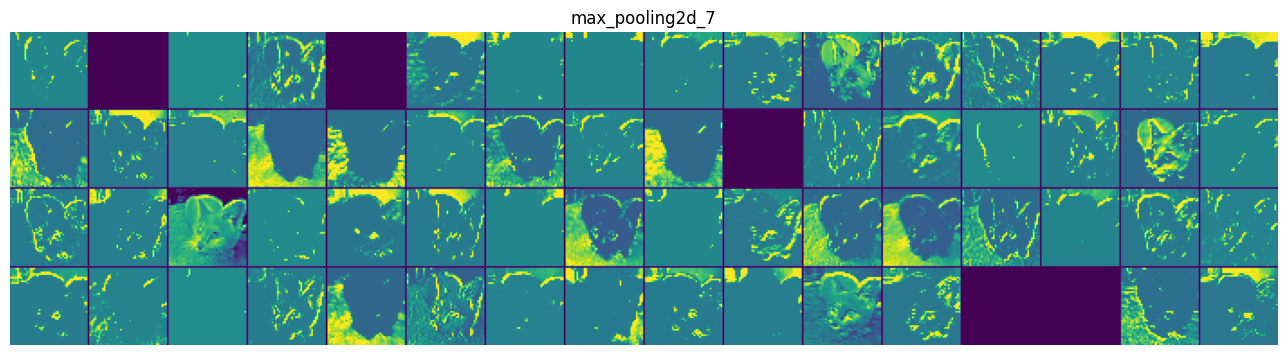

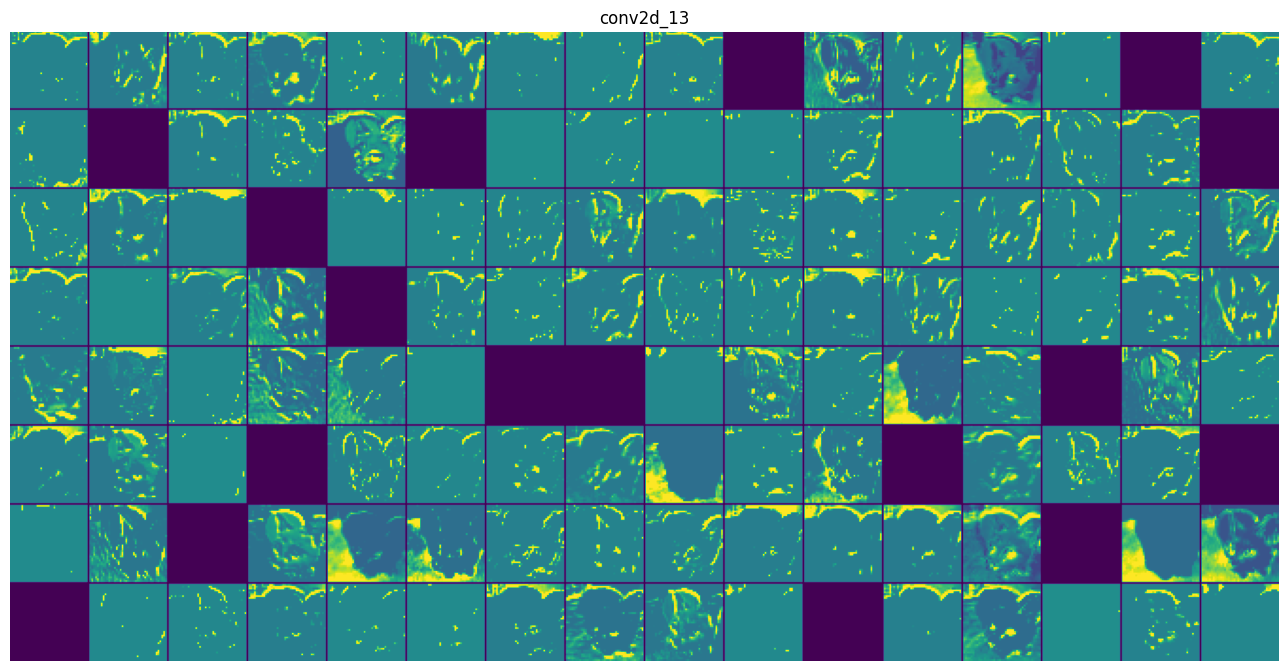

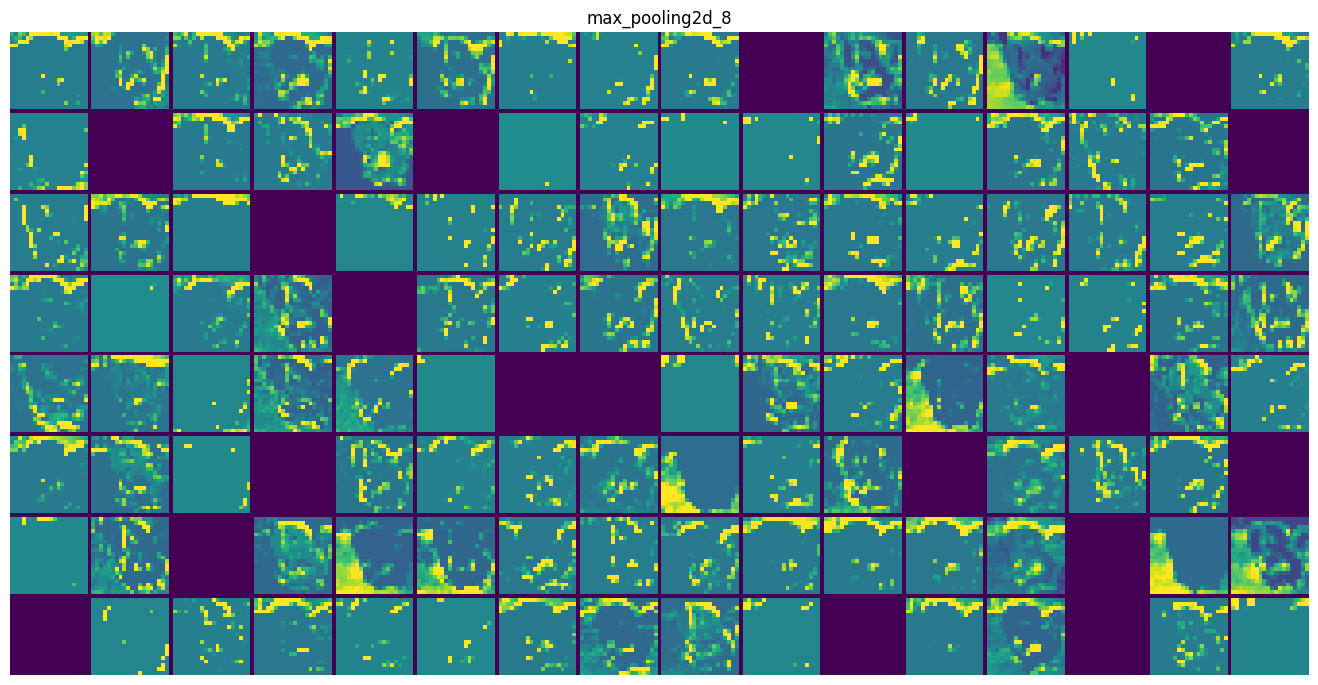

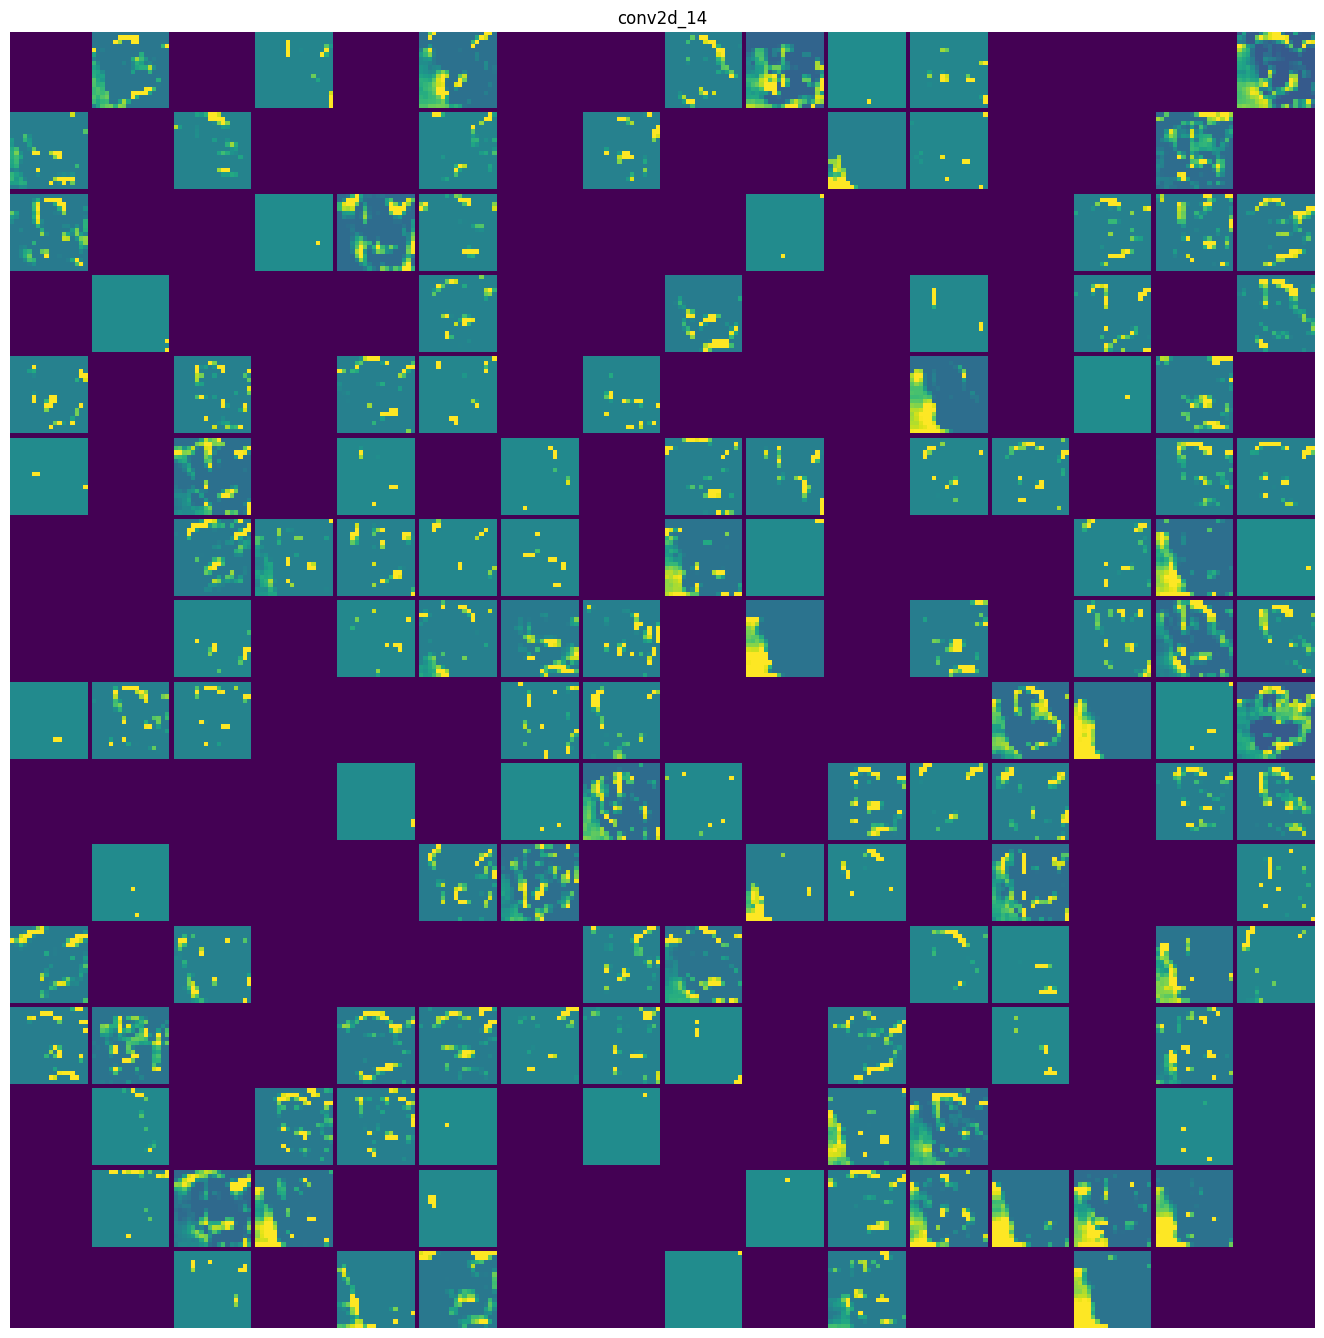

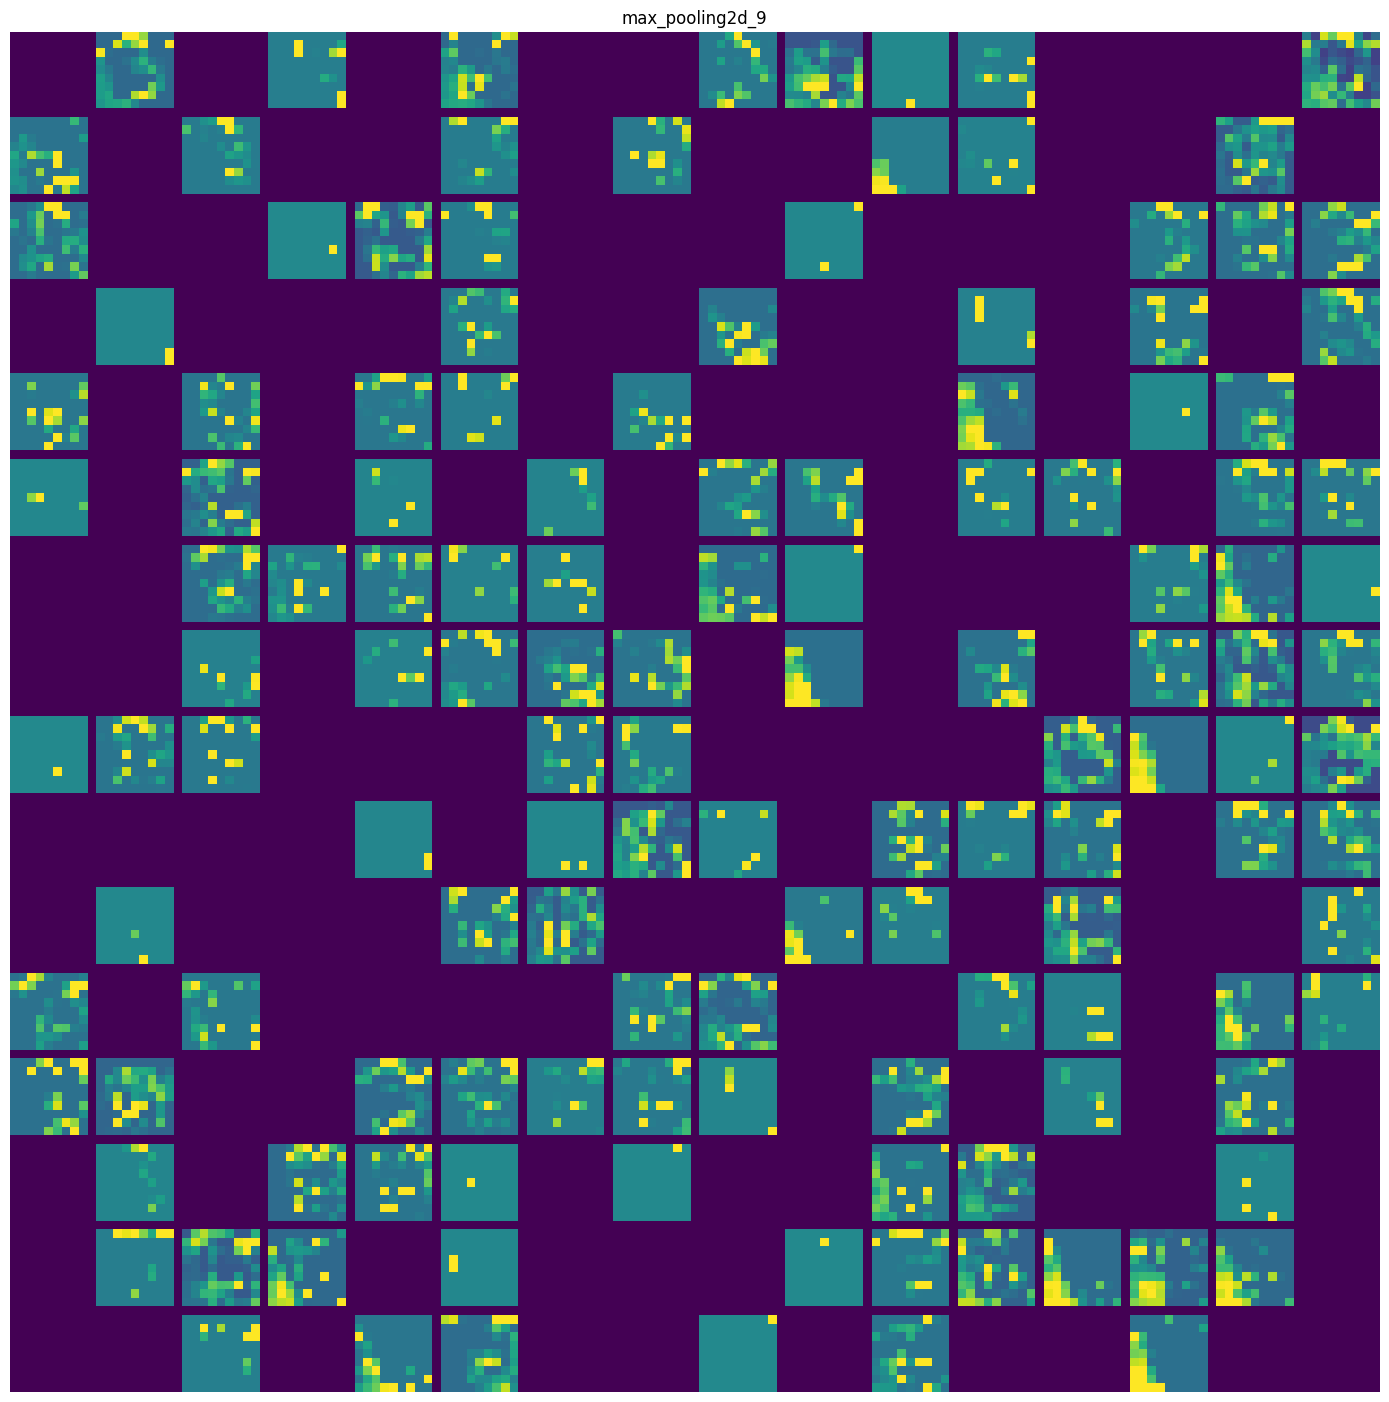

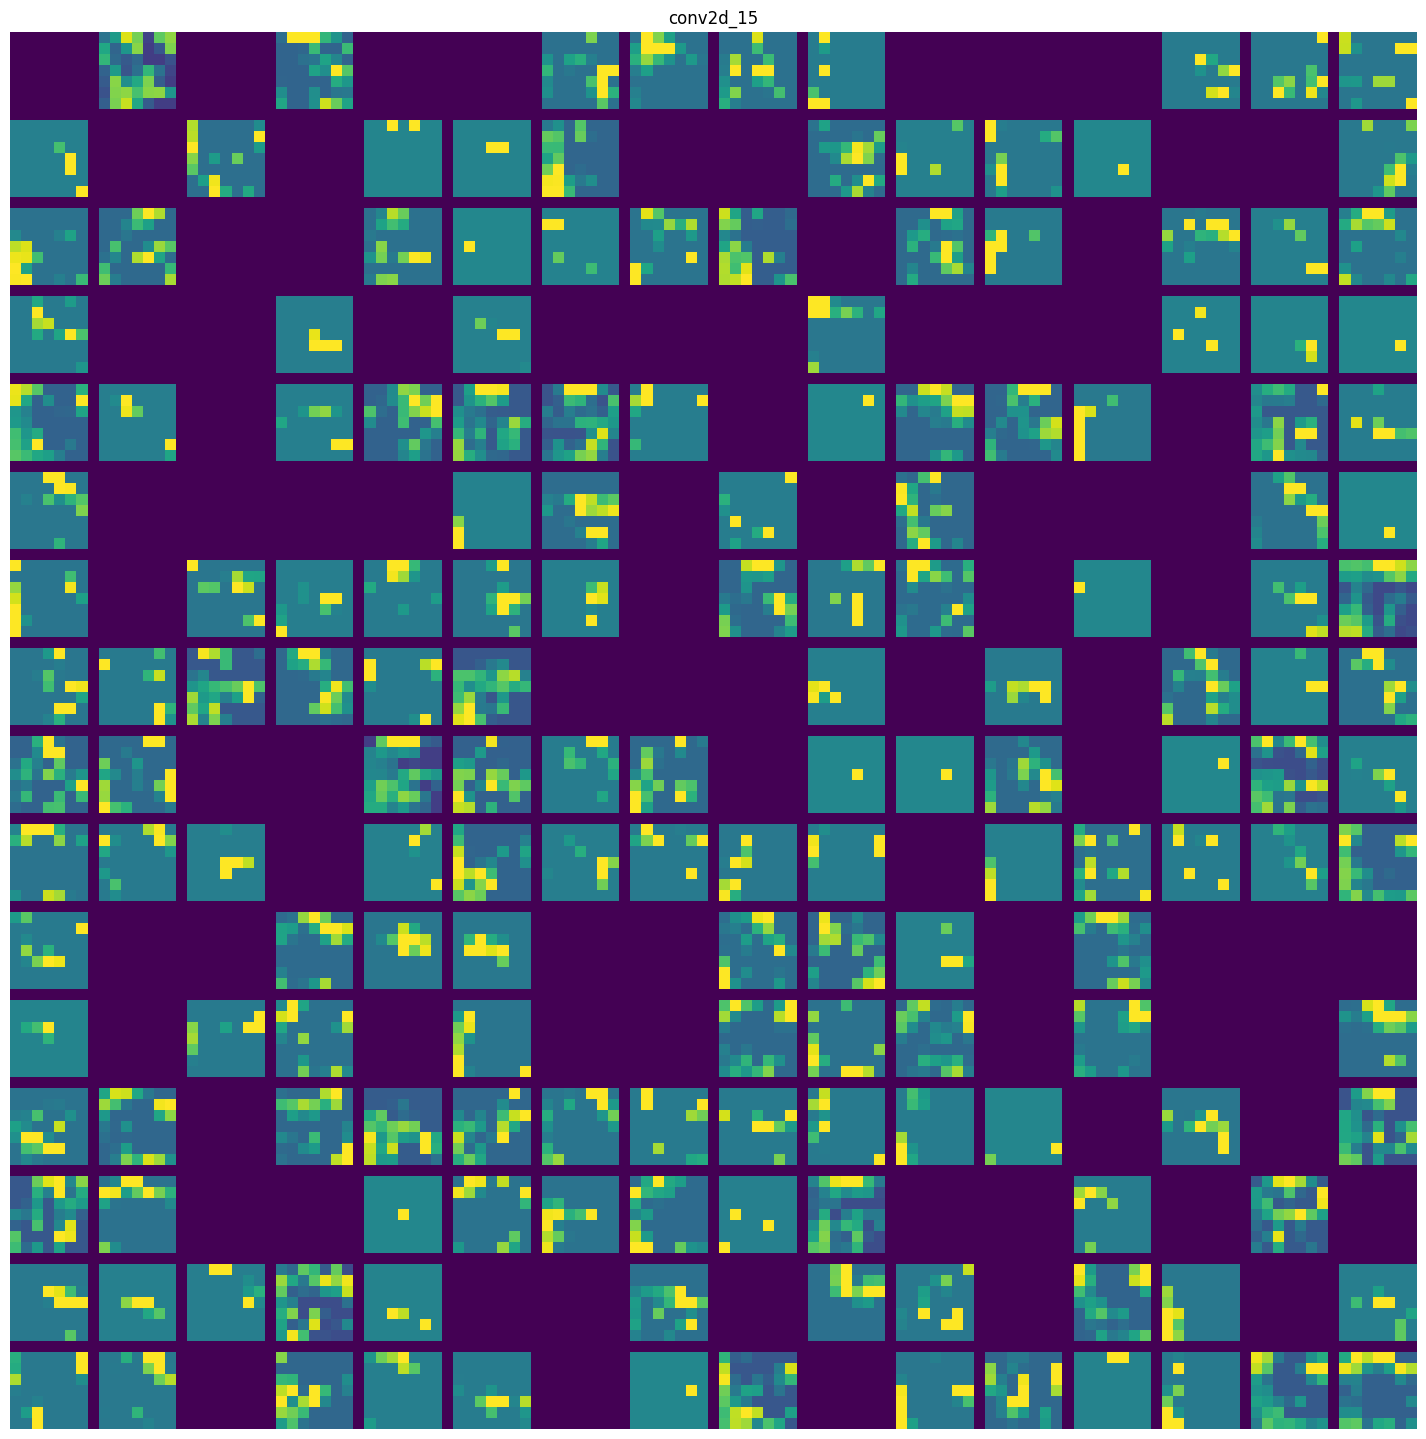

In [ ]:
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros(((size + 1) * n_cols - 1,
                             images_per_row * (size + 1) - 1))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_index = col * images_per_row + row
            channel_image = layer_activation[0, :, :, channel_index].copy()
            if channel_image.sum() != 0:
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype("uint8")
            display_grid[
                col * (size + 1): (col + 1) * size + col,
                row * (size + 1) : (row + 1) * size + row] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.axis("off")
    plt.imshow(display_grid, aspect="auto", cmap="viridis")

### 컨브넷 필터 시각화하기

**Xception 합성곱 기반 모델 만들기**

In [ ]:
model = keras.applications.xception.Xception(
    weights="imagenet",
    include_top=False)

**Xception에 있는 모든 합성곱 층의 이름 출력하기**

In [ ]:
for layer in model.layers:
    if isinstance(layer, (keras.layers.Conv2D, keras.layers.SeparableConv2D)):
        print(layer.name)

**특성 추출 모델 만들기**

In [ ]:
layer_name = "block3_sepconv1"
layer = model.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=model.input, outputs=layer.output)

**특성 추출 모델 사용하기**

In [ ]:
activation = feature_extractor(
    keras.applications.xception.preprocess_input(img_tensor)
)

In [ ]:
import tensorflow as tf

def compute_loss(image, filter_index):
    activation = feature_extractor(image)
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(filter_activation)

**확률적 경사 상승법을 사용한 손실 최대화**

In [ ]:
@tf.function
def gradient_ascent_step(image, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = compute_loss(image, filter_index)
    grads = tape.gradient(loss, image)
    grads = tf.math.l2_normalize(grads)
    image += learning_rate * grads
    return image

**필터 시각화 생성 함수**

In [ ]:
img_width = 200
img_height = 200

def generate_filter_pattern(filter_index):
    iterations = 30
    learning_rate = 10.
    image = tf.random.uniform(
        minval=0.4,
        maxval=0.6,
        shape=(1, img_width, img_height, 3))
    for i in range(iterations):
        image = gradient_ascent_step(image, filter_index, learning_rate)
    return image[0].numpy()

**텐서를 이미지로 변환하기 위한 유틸리티 함수**

In [ ]:
def deprocess_image(image):
    image -= image.mean()
    image /= image.std()
    image *= 64
    image += 128
    image = np.clip(image, 0, 255).astype("uint8")
    image = image[25:-25, 25:-25, :]
    return image

In [ ]:
plt.axis("off")
plt.imshow(deprocess_image(generate_filter_pattern(filter_index=2)))
plt.show()

**층에 있는 모든 필터의 응답 패턴에 대한 그리드 생성하기**

In [ ]:
all_images = []
for filter_index in range(64):
    print(f"{filter_index}번 필터 처리중")
    image = deprocess_image(
        generate_filter_pattern(filter_index)
    )
    all_images.append(image)

margin = 5
n = 8
cropped_width = img_width - 25 * 2
cropped_height = img_height - 25 * 2
width = n * cropped_width + (n - 1) * margin
height = n * cropped_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

for i in range(n):
    for j in range(n):
        image = all_images[i * n + j]
        stitched_filters[
            (cropped_width + margin) * i : (cropped_width + margin) * i + cropped_width,
            (cropped_height + margin) * j : (cropped_height + margin) * j
            + cropped_height,
            :,
        ] = image

keras.utils.save_img(
    f"filters_for_layer_{layer_name}.png", stitched_filters)

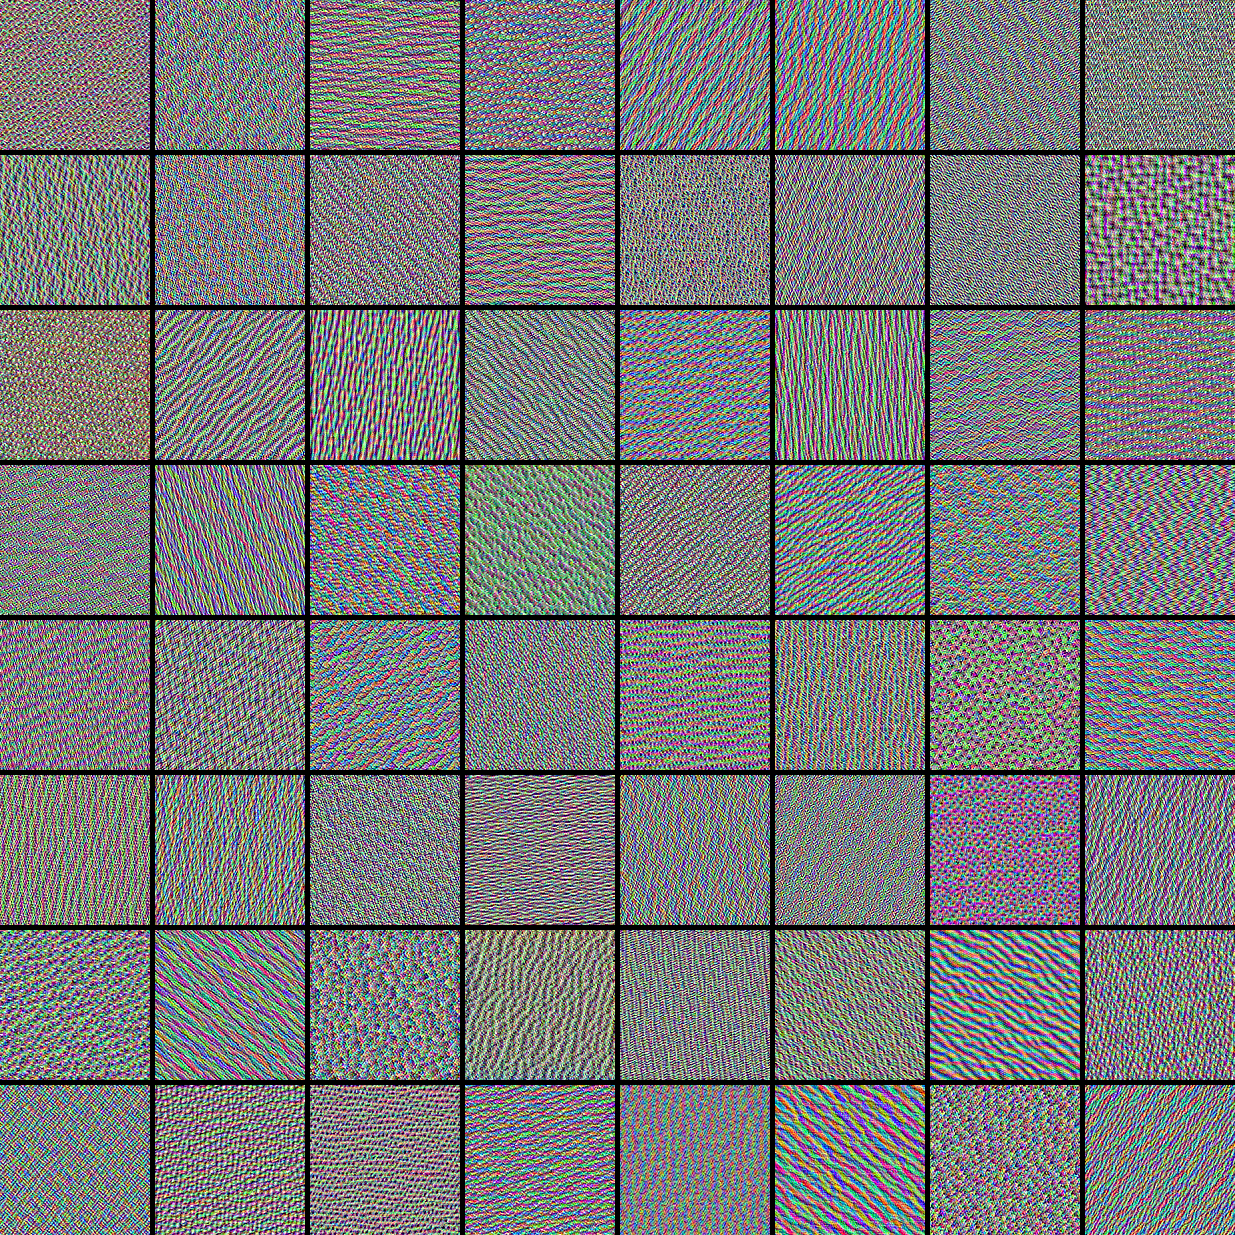

In [ ]:
from IPython.display import Image

Image(f"filters_for_layer_{layer_name}.png")

### 클래스 활성화의 히트맵 시각화하기

**사전 훈련된 가중치로 Xception 네트워크 로드하기**

In [ ]:
model = keras.applications.xception.Xception(weights="imagenet")

91884032/91884032 [==============================] - 5s 0us/step


**Xception 모델에 맞게 입력 이미지를 전처리하기**

In [ ]:
img_path = keras.utils.get_file(
    fname="elephant.jpg",
    origin="https://img-datasets.s3.amazonaws.com/elephant.jpg")

def get_img_array(img_path, target_size):
    img = keras.utils.load_img(img_path, target_size=target_size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    array = keras.applications.xception.preprocess_input(array)
    return array

img_array = get_img_array(img_path, target_size=(299, 299))

733657/733657 [==============================] - 1s 1us/step


In [ ]:
preds = model.predict(img_array)
print(keras.applications.xception.decode_predictions(preds, top=3)[0])

35363/35363 [==============================] - 0s 5us/step
[('n02504458', 'African_elephant', 0.86993945), ('n01871265', 'tusker', 0.076956384), ('n02504013', 'Indian_elephant', 0.023541829)]


In [ ]:
np.argmax(preds[0])

386

**마지막 합성곱 출력을 반환하는 모델 만들기**

In [ ]:
last_conv_layer_name = "block14_sepconv2_act"
classifier_layer_names = [
    "avg_pool",
    "predictions",
]
last_conv_layer = model.get_layer(last_conv_layer_name)
last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

**마지막 합성곱 출력 위에 있는 분류기에 적용하기 위한 모델 만들기**

In [ ]:
classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
    x = model.get_layer(layer_name)(x)
classifier_model = keras.Model(classifier_input, x)

**최상위 예측 클래스의 그레이디언트 계산하기**

In [ ]:
import tensorflow as tf

with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(img_array)
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

grads = tape.gradient(top_class_channel, last_conv_layer_output)

**그레이디언트를 평균하고 채널 중요도 가중치 적용하기**

In [ ]:
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()
last_conv_layer_output = last_conv_layer_output.numpy()[0]
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]
heatmap = np.mean(last_conv_layer_output, axis=-1)

**히트맵 후처리하기**

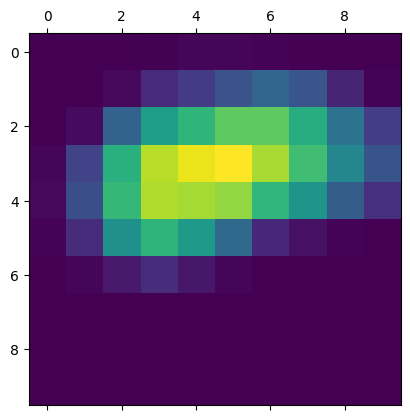

In [ ]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

**원본 이미지 위에 히트맵 그리기**

In [ ]:
import matplotlib.cm as cm

img = keras.utils.load_img(img_path)
img = keras.utils.img_to_array(img)

heatmap = np.uint8(255 * heatmap)

jet = cm.get_cmap("jet")
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

jet_heatmap = keras.utils.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.utils.img_to_array(jet_heatmap)

superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.utils.array_to_img(superimposed_img)

save_path = "elephant_cam.jpg"
superimposed_img.save(save_path)

<ipython-input-30-edce8dd3ddee>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


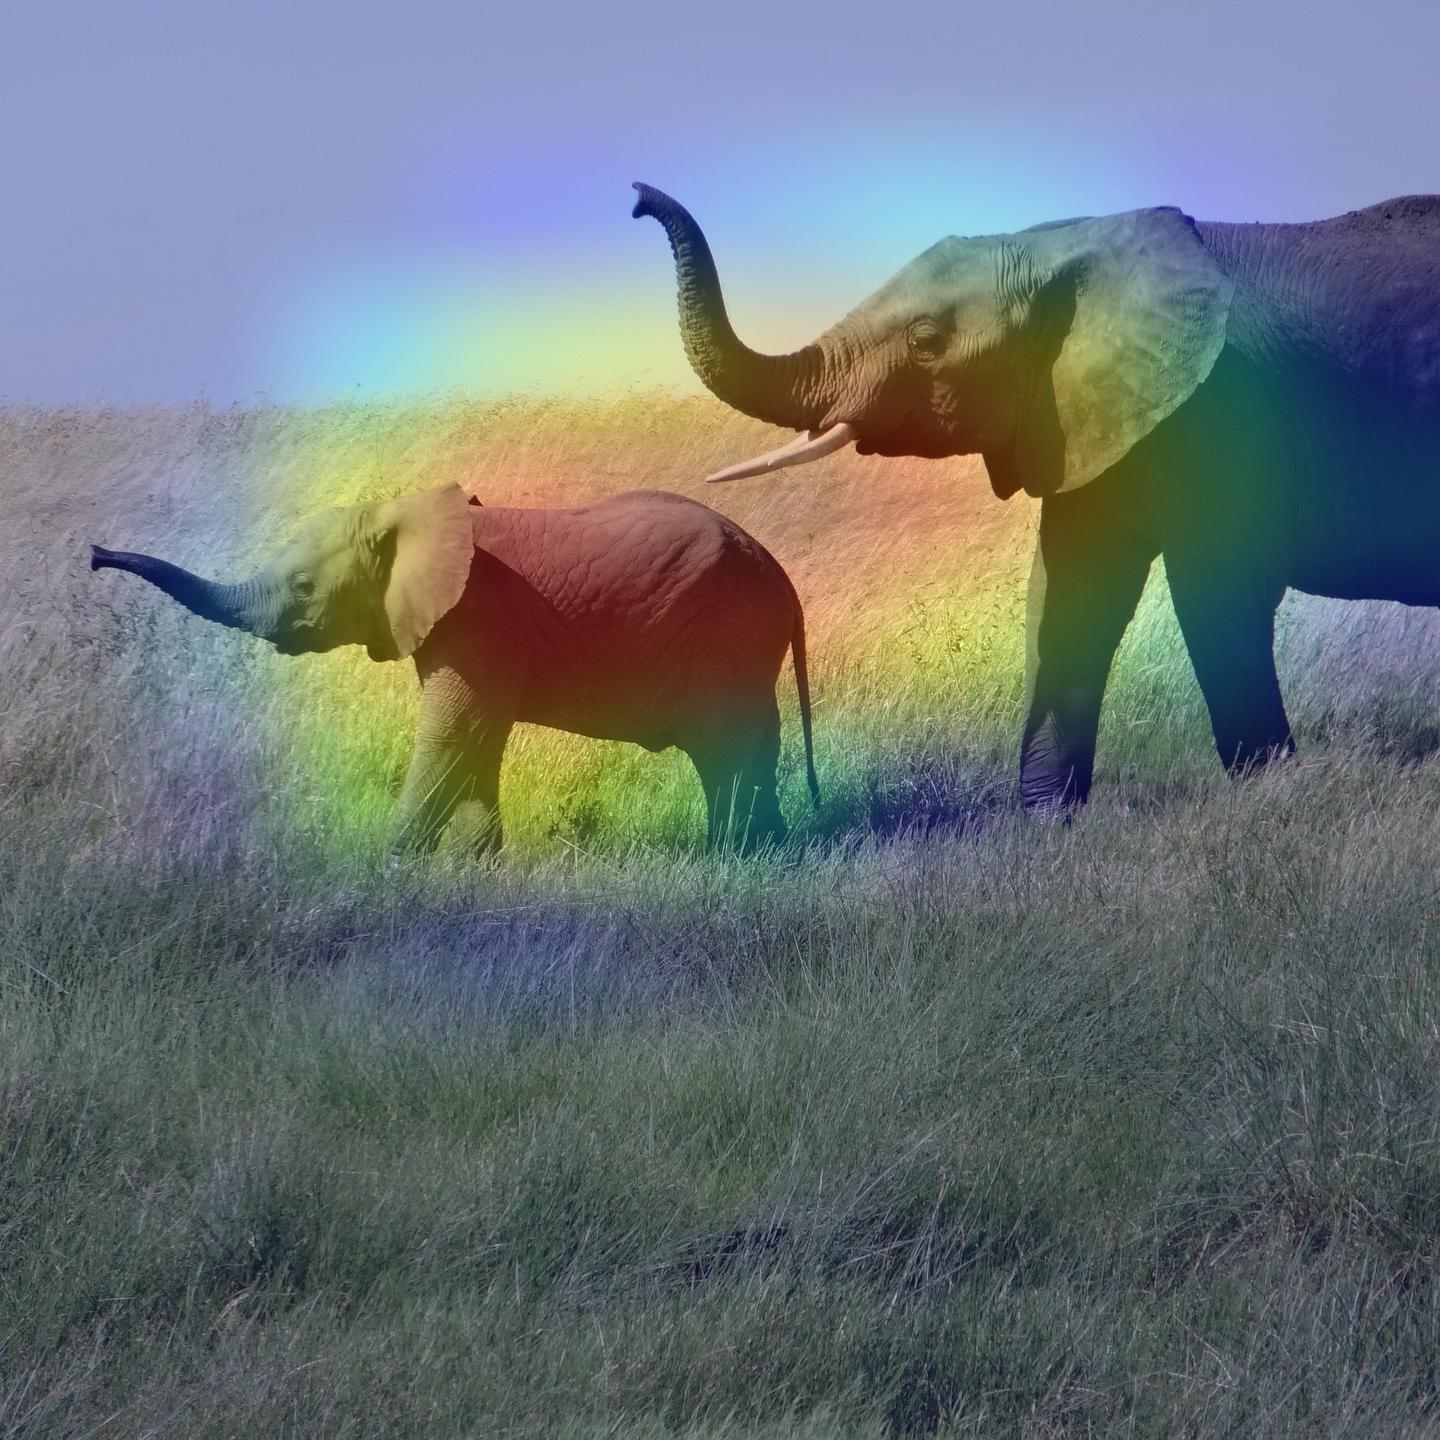

In [ ]:
Image("elephant_cam.jpg")

## 요약